In [44]:


import numpy as np 
%pip install plotly==5.8.0
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import seaborn as sb
import statsmodels.api as sm
import plotly.express as px
%pip install kaleido
import kaleido
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from collections import Counter
from sklearn.model_selection import cross_validate,train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn import metrics
from sklearn.metrics import r2_score,silhouette_score,confusion_matrix,accuracy_score
pd.set_option("display.precision",3)
np.set_printoptions(precision=5, suppress=True)
pd.options.display.float_format = '{:.4f}'.format
import plotly.io as pio

pio.renderers.default = "svg"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Read the data

In [45]:
df = pd.read_csv('//kaggle//input//ev-market//data (1).csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df['inr(10e3)'] = df['PriceEuro']*0.09079
df['RapidCharge'].replace(to_replace=['No','Yes'],value=[0, 1],inplace=True)
df.head()

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro,inr(10e3)
0,Tesla,Model 3 Long Range Dual Motor,4.6000,233,450,161,940,1,AWD,Type 2 CCS,Sedan,D,5,55480,5037.0292
1,Volkswagen,ID.3 Pure,10.0000,160,270,167,250,0,RWD,Type 2 CCS,Hatchback,C,5,30000,2723.7000
2,Polestar,2,4.7000,210,400,181,620,1,AWD,Type 2 CCS,Liftback,D,5,56440,5124.1876
3,BMW,iX3,6.8000,180,360,206,560,1,RWD,Type 2 CCS,SUV,D,5,68040,6177.3516
4,Honda,e,9.5000,145,170,168,190,1,RWD,Type 2 CCS,Hatchback,B,4,32997,2995.7976


In [46]:
df[(df['Brand'] == 'Tesla ') | (df['Brand'] == 'BMW ')]

,Brand,Model,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,PowerTrain,PlugType,BodyStyle,Segment,Seats,PriceEuro,inr(10e3)
0,Tesla,Model 3 Long Range Dual Motor,4.6000,233,450,161,940,1,AWD,Type 2 CCS,Sedan,D,5,55480,5037.0292
3,BMW,iX3,6.8000,180,360,206,560,1,RWD,Type 2 CCS,SUV,D,5,68040,6177.3516
8,Tesla,Model 3 Standard Range Plus,5.6000,225,310,153,650,1,RWD,Type 2 CCS,Sedan,D,5,46380,4210.8402
13,BMW,i4,4.0000,200,450,178,650,1,RWD,Type 2 CCS,Sedan,D,5,65000,5901.3500
21,Tesla,Model Y Long Range Dual Motor,5.1000,217,425,171,930,1,AWD,Type 2 CCS,SUV,D,7,58620,5322.1098
24,Tesla,Model 3 Long Range Performance,3.4000,261,435,167,910,1,AWD,Type 2 CCS,Sedan,D,5,61480,5581.7692
28,BMW,i3 120 Ah,7.3000,150,235,161,270,0,RWD,Type 2 CCS,Hatchback,B,4,38017,3451.5634
33,Tesla,Cybertruck Tri Motor,3.0000,210,750,267,710,1,AWD,Type 2 CCS,Pickup,N,6,75000,6809.2500
40,Tesla,Model S Long Range,3.8000,250,515,184,560,1,AWD,Type 2,Liftback,F,5,79990,7262.2921
51,Tesla,Roadster,2.1000,410,970,206,920,1,AWD,Type 2 CCS,Cabrio,S,4,215000,19519.8500


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Brand            103 non-null    object 
 1   Model            103 non-null    object 
 2   AccelSec         103 non-null    float64
 3   TopSpeed_KmH     103 non-null    int64  
 4   Range_Km         103 non-null    int64  
 5   Efficiency_WhKm  103 non-null    int64  
 6   FastCharge_KmH   103 non-null    int64  
 7   RapidCharge      103 non-null    int64  
 8   PowerTrain       103 non-null    object 
 9   PlugType         103 non-null    object 
 10  BodyStyle        103 non-null    object 
 11  Segment          103 non-null    object 
 12  Seats            103 non-null    int64  
 13  PriceEuro        103 non-null    int64  
 14  inr(10e3)        103 non-null    float64
dtypes: float64(2), int64(7), object(6)
memory usage: 12.2+ KB


In [48]:
df.isnull().sum()

Brand              0
Model              0
AccelSec           0
TopSpeed_KmH       0
Range_Km           0
Efficiency_WhKm    0
FastCharge_KmH     0
RapidCharge        0
PowerTrain         0
PlugType           0
BodyStyle          0
Segment            0
Seats              0
PriceEuro          0
inr(10e3)          0
dtype: int64

In [49]:
df.describe()

,AccelSec,TopSpeed_KmH,Range_Km,Efficiency_WhKm,FastCharge_KmH,RapidCharge,Seats,PriceEuro,inr(10e3)
count,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000,103.0000
mean,7.3961,179.1942,338.7864,189.1650,444.2718,0.7476,4.8835,55811.5631,5067.1318
std,3.0174,43.5730,126.0144,29.5668,203.9493,0.4365,0.7958,34134.6653,3099.0863
min,2.1000,123.0000,95.0000,104.0000,170.0000,0.0000,2.0000,20129.0000,1827.5119
25%,5.1000,150.0000,250.0000,168.0000,260.0000,0.5000,5.0000,34429.5000,3125.8543
50%,7.3000,160.0000,340.0000,180.0000,440.0000,1.0000,5.0000,45000.0000,4085.5500
75%,9.0000,200.0000,400.0000,203.0000,555.0000,1.0000,5.0000,65000.0000,5901.3500
max,22.4000,410.0000,970.0000,273.0000,940.0000,1.0000,7.0000,215000.0000,19519.8500


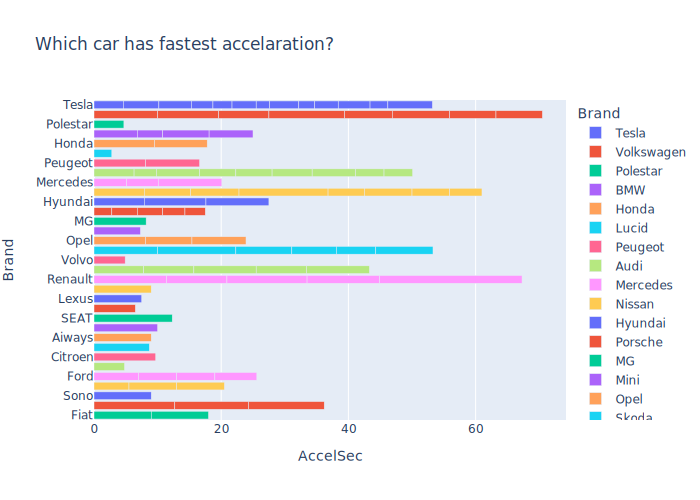

In [50]:
import plotly.io as pio
fig = px.bar(df,x='AccelSec',y = 'Brand',color = 'Brand',title = 'Which car has fastest accelaration?',labels = {'x':'Accelaration','y':'Car Brands'})
pio.show(fig)

## Heatmap to show the correlation of the data

/tmp/ipykernel_29/3278579179.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



<Axes: >

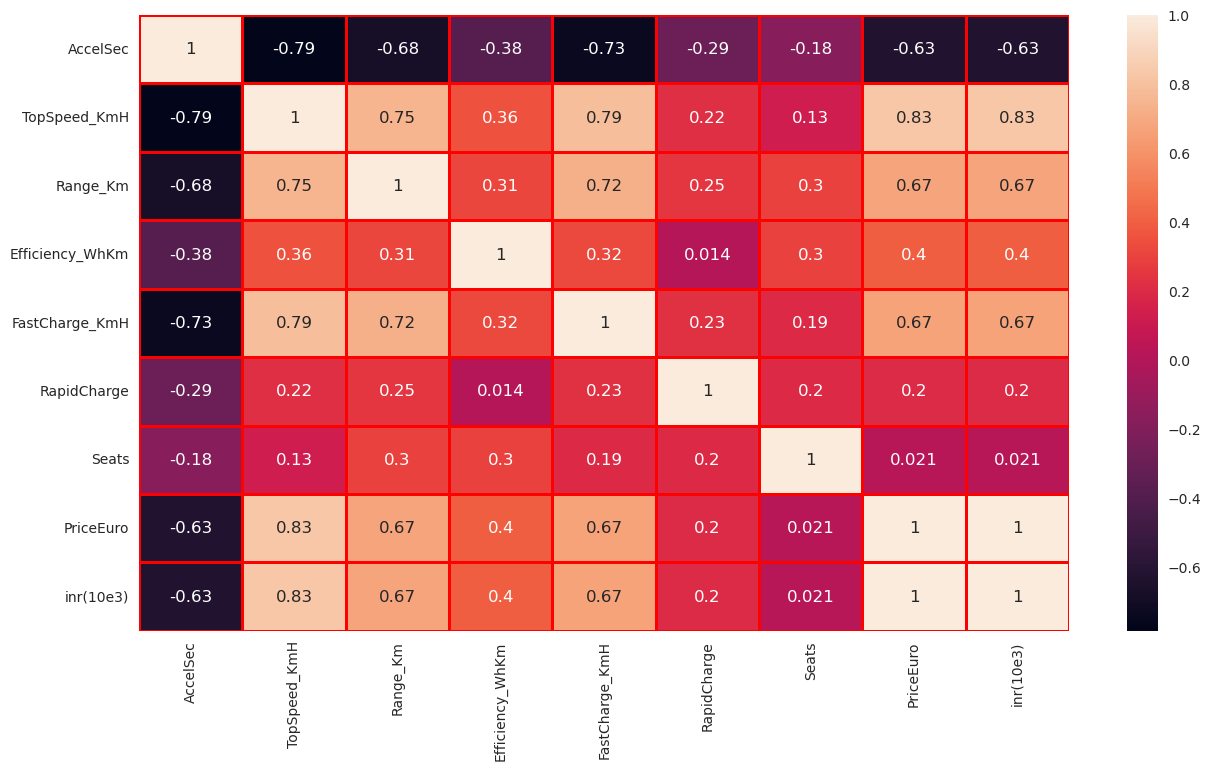

In [52]:
ax= plt.figure(figsize=(15,8))
sb.heatmap(df.corr(),linewidths=1,linecolor='red',annot=False)

In [53]:
a=np.arange(1,104)



## Type of Plug used for charging

Text(0.5, 1.0, 'Plug Type')

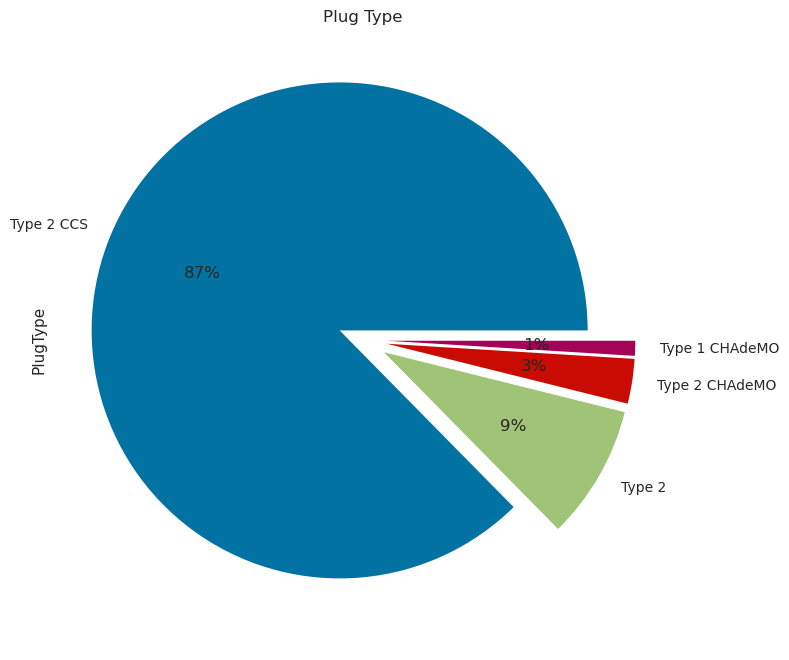

In [56]:
df['PlugType'].value_counts().plot.pie(figsize=(8,15),autopct='%.0f%%',explode=(.1,.1,.1,.1))
plt.title('Plug Type')


## Segment in which the cars fall under

Text(0.5, 1.0, 'Segment')

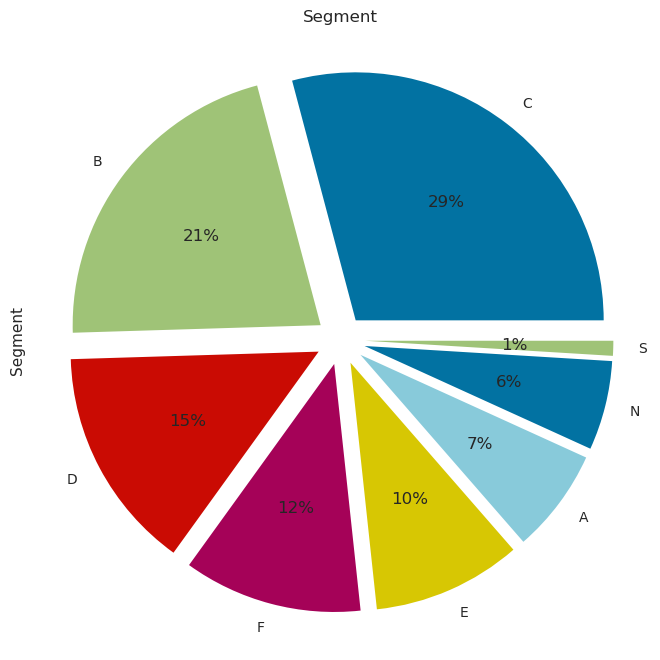

In [57]:
df['Segment'].value_counts().plot.pie(figsize=(8,15),autopct='%.0f%%',explode=(0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1))
plt.title('Segment')

Majority of cars have 5 seats

In [58]:
df3= df[["TopSpeed_KmH", "inr(10e3)"]].groupby("TopSpeed_KmH").count()
df4= df[["Range_Km", "inr(10e3)"]].groupby("Range_Km").count()
df5= df[["Range_Km", "TopSpeed_KmH"]].groupby("Range_Km").count()
df5.head()

,TopSpeed_KmH
Range_Km,
95,2
100,1
130,1
160,1
170,2


## Clustering

<Axes: xlabel='TopSpeed_KmH', ylabel='FastCharge_KmH'>

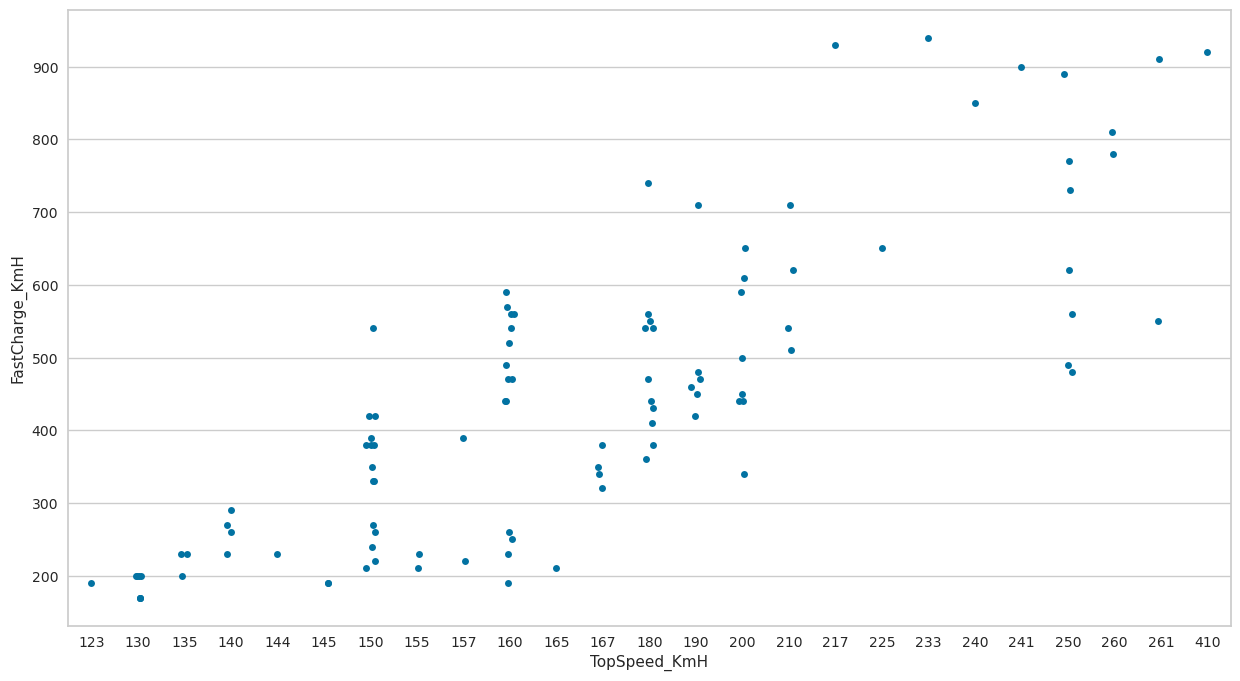

In [59]:
ax=plt.subplots(figsize=(15,8))
sb.stripplot(x='TopSpeed_KmH', y='FastCharge_KmH', data=df, jitter=True)

<Axes: xlabel='TopSpeed_KmH', ylabel='Efficiency_WhKm'>

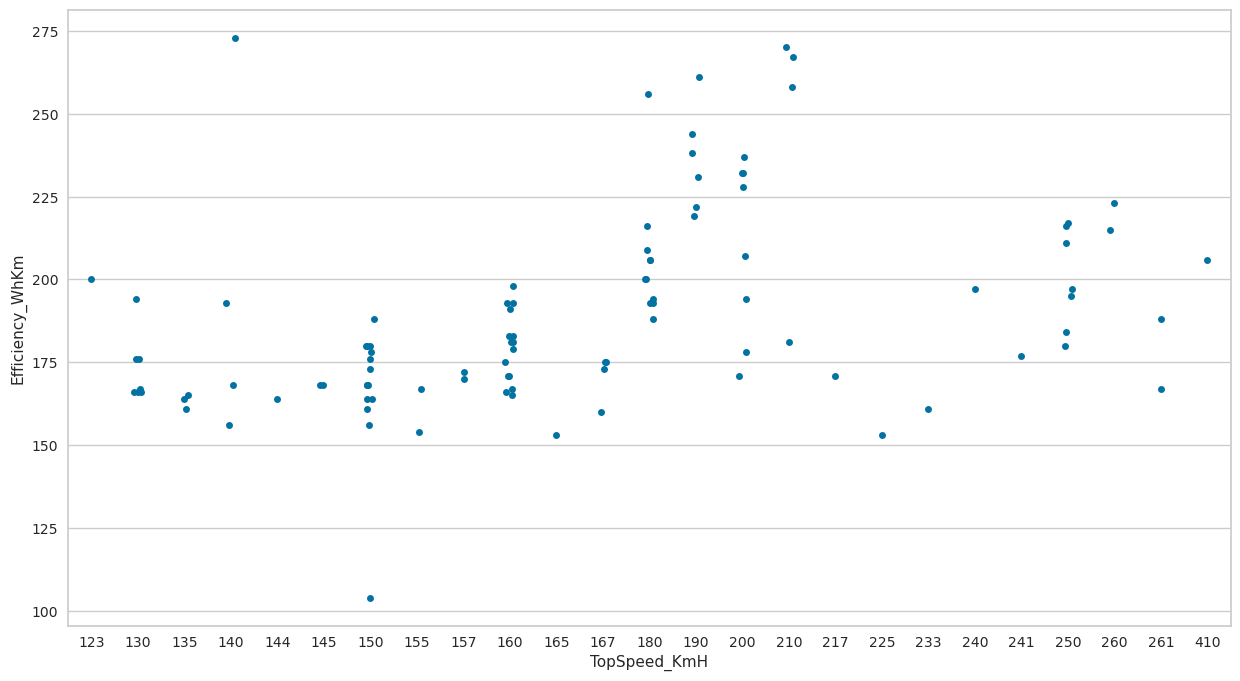

In [60]:
ax=plt.subplots(figsize=(15,8))
sb.stripplot(x='TopSpeed_KmH', y='Efficiency_WhKm', data=df, jitter=True)

In [61]:
pd.set_option("display.precision",3)
np.set_printoptions(precision=5, suppress=True)
pd.options.display.float_format = '{:.4f}'.format

In [62]:
features = ['AccelSec','TopSpeed_KmH','Efficiency_WhKm','FastCharge_KmH', 'RapidCharge','Range_Km', 'Seats', 'inr(10e3)']
# Separating out the features
x = df.loc[:, features].values
x = StandardScaler().fit_transform(x)

In [63]:
pca = PCA(n_components=8)
t = pca.fit_transform(x)
data2 = pd.DataFrame(t, columns=['PC1', 'PC2','PC3','PC4','Pc5','PC6', 'PC7', 'PC8'])
data2

,PC1,PC2,PC3,PC4,Pc5,PC6,PC7,PC8
0,2.2253,-0.4726,-1.1845,-1.2892,-0.9006,0.1985,1.1025,-0.3594
1,-1.9503,-0.2687,0.9699,-1.1035,0.1925,-0.2831,-0.3082,-0.2158
2,1.3190,-0.0309,-0.7051,-0.3345,-0.5912,-0.0183,0.0750,-0.1742
3,0.8051,0.3305,-0.1119,0.4722,-0.0212,0.1641,0.3829,0.2070
4,-2.2457,-0.5068,-0.9012,0.9035,-0.0613,-0.2750,-0.1737,-0.0832
...,...,...,...,...,...,...,...,...
98,-0.2493,0.5006,-0.4159,0.2624,-0.1689,0.2339,0.0893,0.1456
99,2.0774,0.4873,0.9716,1.8056,-0.1220,-0.3080,0.0908,0.1381
100,0.4542,0.2863,-0.3731,0.3154,-0.3874,-0.2720,-0.1948,-0.3431
101,1.2479,0.5590,0.3967,1.0905,-0.2812,0.0969,-0.3412,-0.1732


In [64]:
df_8=data2.iloc[:,:8]
df_8.head(3)

,PC1,PC2,PC3,PC4,Pc5,PC6,PC7,PC8
0,2.2253,-0.4726,-1.1845,-1.2892,-0.9006,0.1985,1.1025,-0.3594
1,-1.9503,-0.2687,0.9699,-1.1035,0.1925,-0.2831,-0.3082,-0.2158
2,1.3190,-0.0309,-0.7051,-0.3345,-0.5912,-0.0183,0.0750,-0.1742


In [65]:
# correlation coefficient between original variables and the component
loadings = pca.components_
num_pca = pca.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pca+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df_8.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:101: FutureWarning:

Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.



,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
variable,,,,,,,,
PC1,-0.4195,0.0534,0.0539,-0.0148,0.6718,0.2010,0.4745,-0.3181
PC2,0.4462,-0.1928,-0.0000,-0.0629,0.0743,-0.3695,-0.0597,-0.7837
PC3,0.2434,0.3061,0.6037,0.6465,-0.0591,0.2187,0.0554,-0.1016
PC4,0.4226,-0.0936,-0.0299,-0.2226,-0.2924,0.1724,0.7965,0.1118
Pc5,0.1640,0.3273,-0.7853,0.4834,0.0529,0.0677,0.0699,-0.0581
PC6,0.4173,0.0267,-0.0463,-0.3176,0.2795,0.7179,-0.3576,-0.0282
PC7,0.1386,0.8261,0.0994,-0.4073,0.1206,-0.3207,0.0174,0.0697
PC8,0.4085,-0.2593,0.0555,0.1671,0.5988,-0.3504,0.0267,0.5028


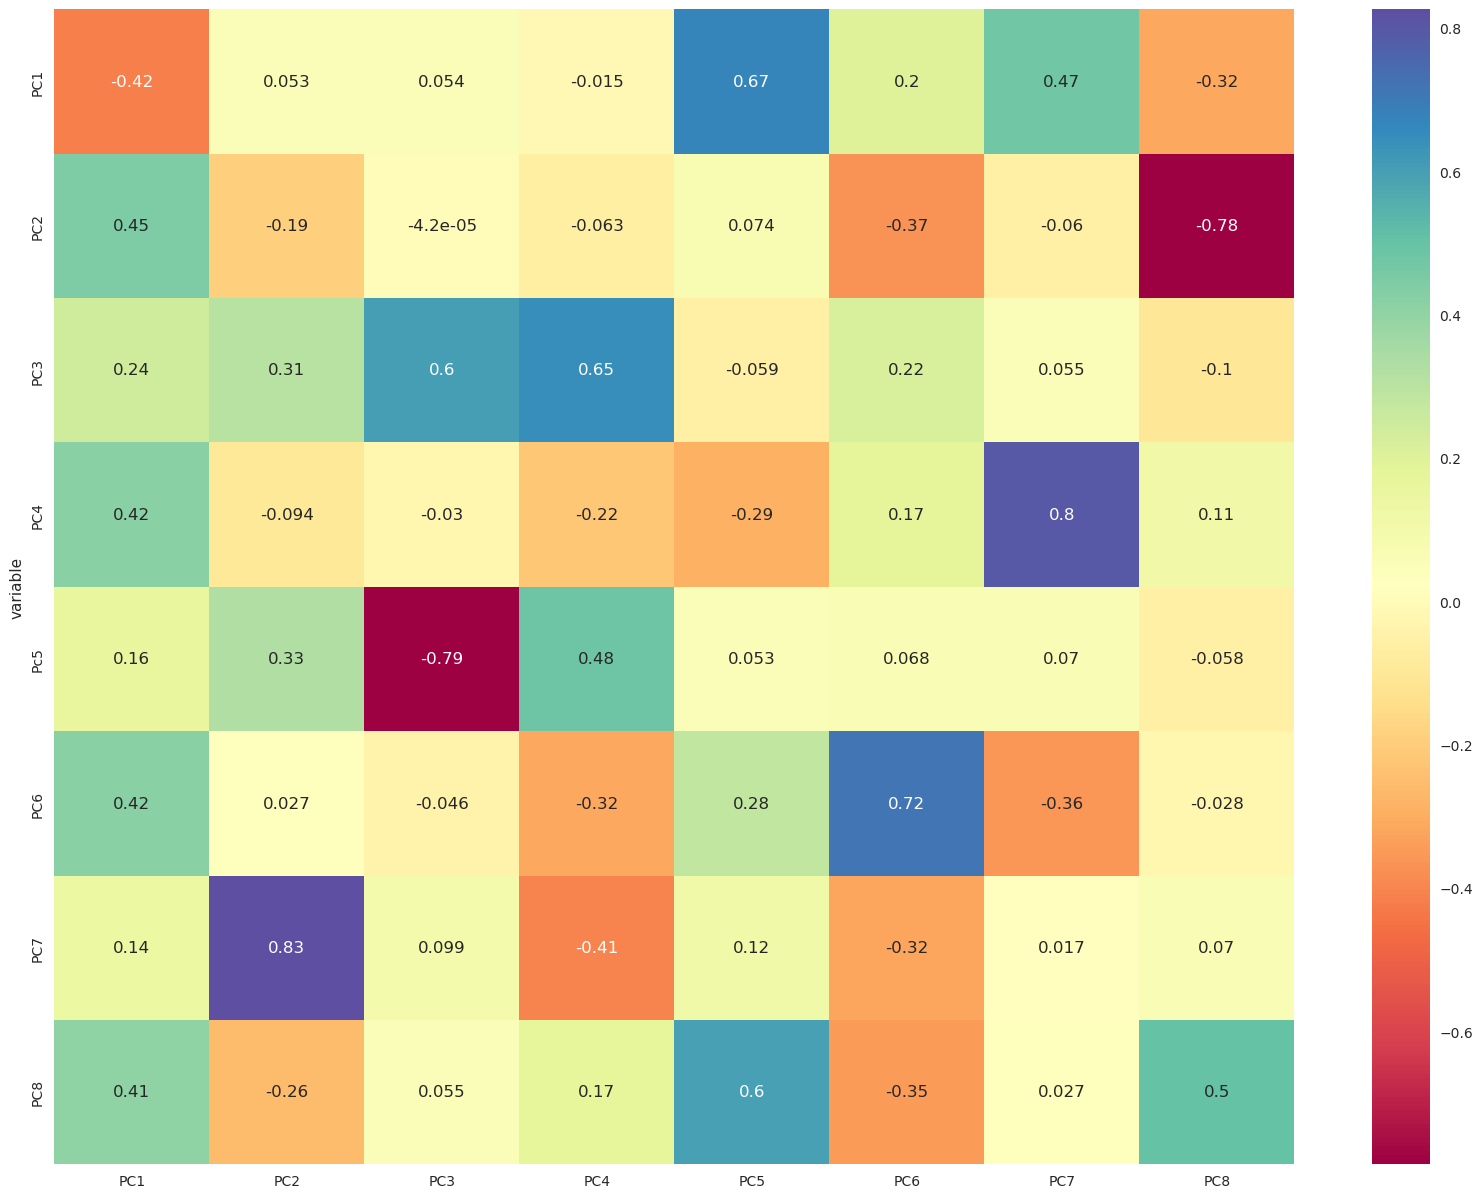

In [66]:
#Correlation matrix plot for loadings 
plt.rcParams['figure.figsize'] = (20,15)
ax = sb.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

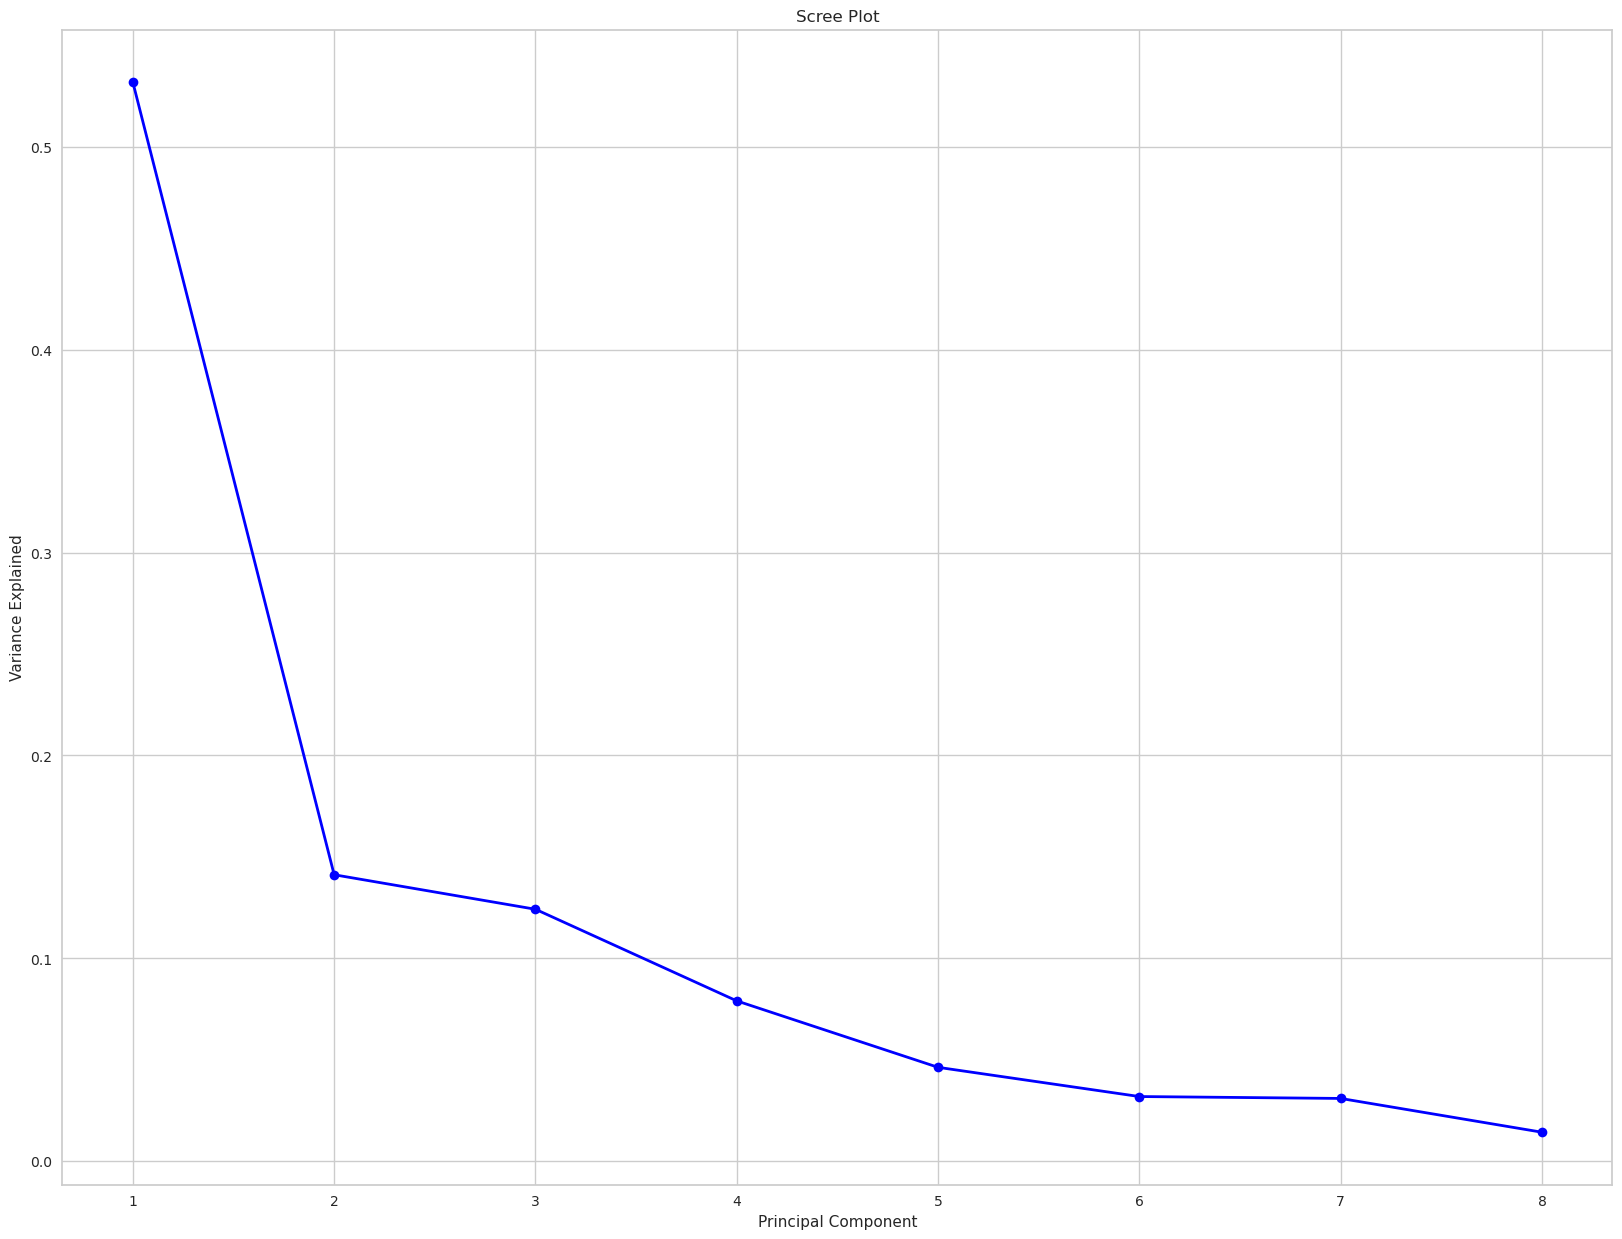

In [67]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

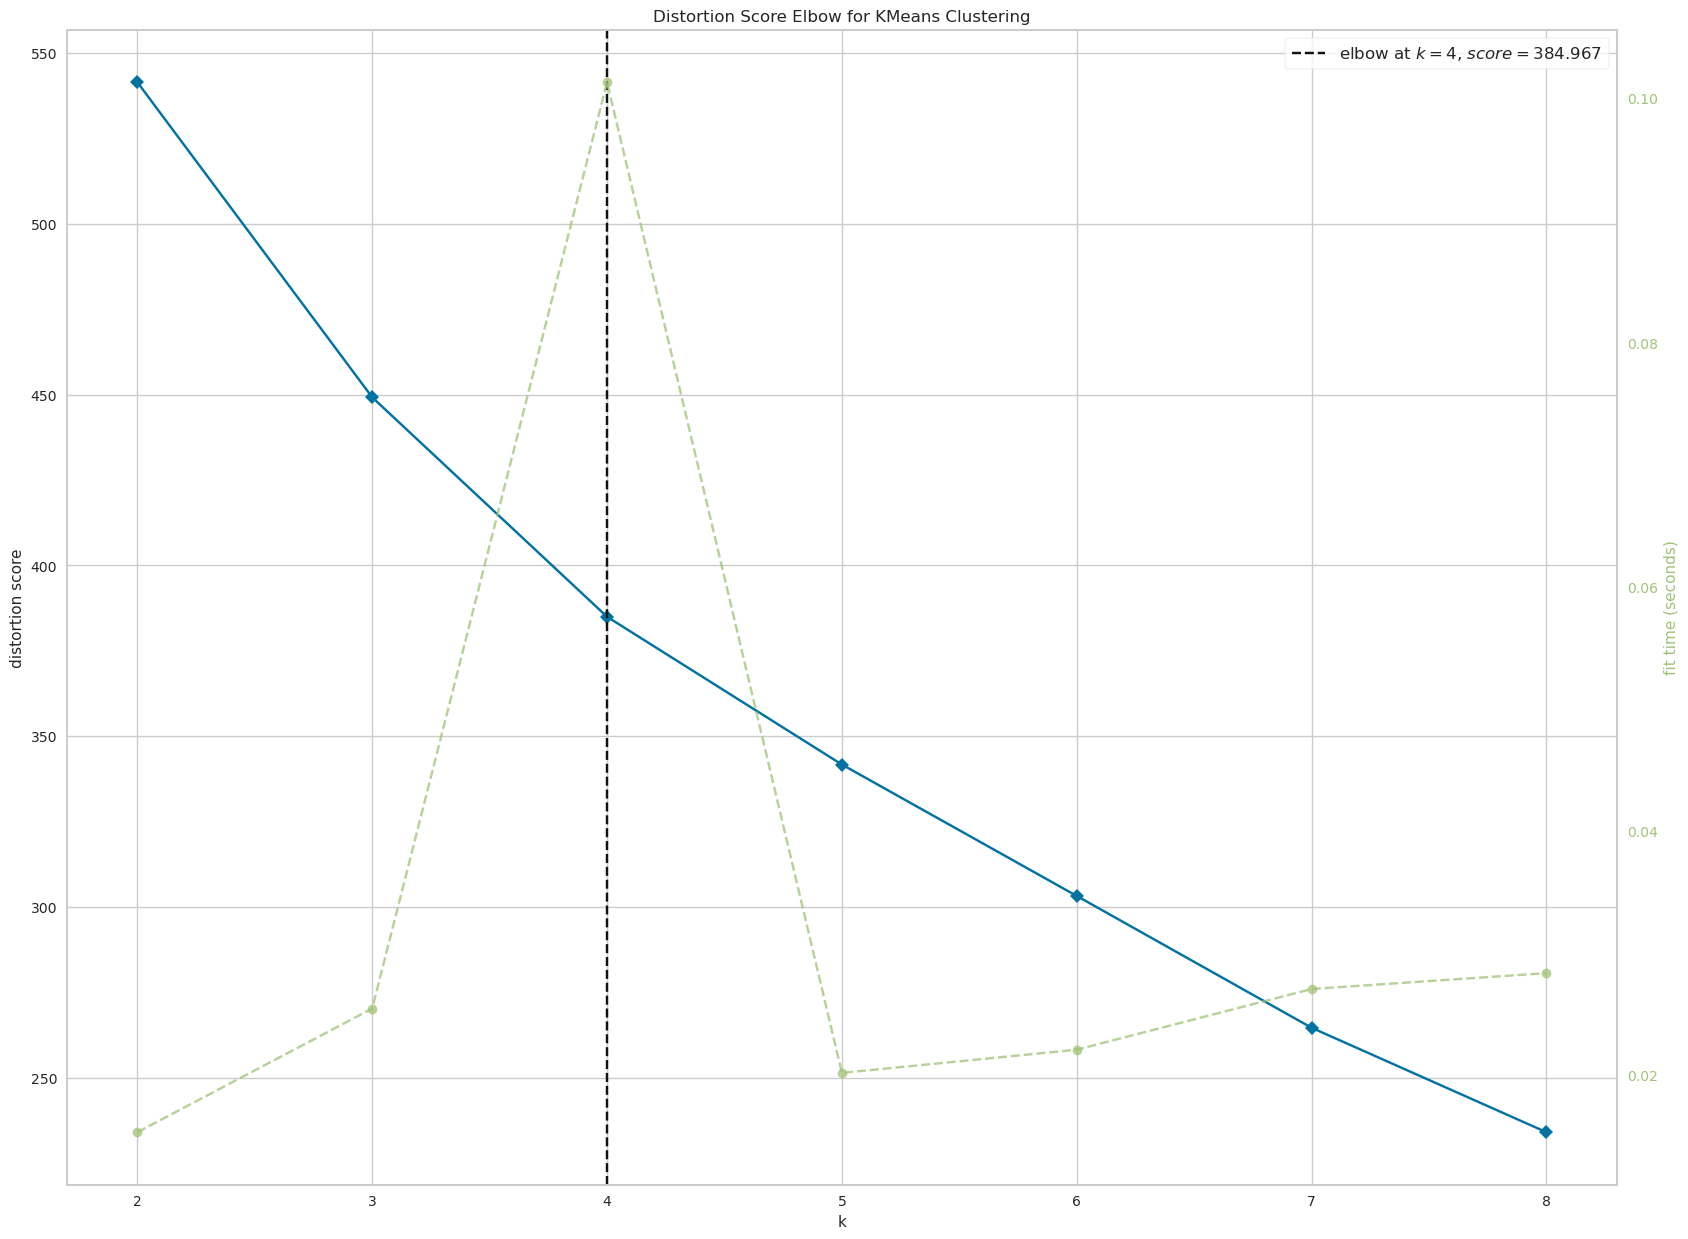

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [68]:
model = KMeans(random_state=40)
visualizer = KElbowVisualizer(model, k=(2,9), metric='distortion', timings=True)
visualizer.fit(t)        
visualizer.show()        

In [71]:
#K-means clustering 

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0).fit(t)
df['cluster_num'] = kmeans.labels_ 
print (kmeans.labels_) 
print (kmeans.inertia_)  
print(kmeans.n_iter_) 
print(kmeans.cluster_centers_) 

[2 1 0 0 3 2 1 1 3 0 0 3 3 0 1 3 2 3 1 3 3 0 3 2 2 3 3 0 1 1 0 3 3 0 3 3 3
 1 1 1 2 3 0 3 3 3 3 2 3 1 0 2 3 3 0 3 3 1 3 2 1 0 0 0 0 2 3 0 1 0 3 1 2 0
 3 3 0 1 0 2 3 0 1 3 0 3 0 0 0 3 0 1 1 0 3 3 3 0 3 0 0 0 0]
383.8627657733399
5
[[ 1.25548  0.68451  0.49117  0.25499 -0.14867  0.07051 -0.01659  0.0121 ]
 [-2.02463 -0.75196  1.04591 -0.65268  0.00179 -0.04768 -0.04162 -0.00266]
 [ 3.41827 -1.36481 -0.3349   0.00387  0.1491  -0.26514  0.20313 -0.10736]
 [-1.12775  0.20708 -0.82211  0.10102  0.07904  0.04514 -0.02819  0.02409]]


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [72]:

Counter(kmeans.labels_)

Counter({3: 39, 0: 33, 1: 19, 2: 12})

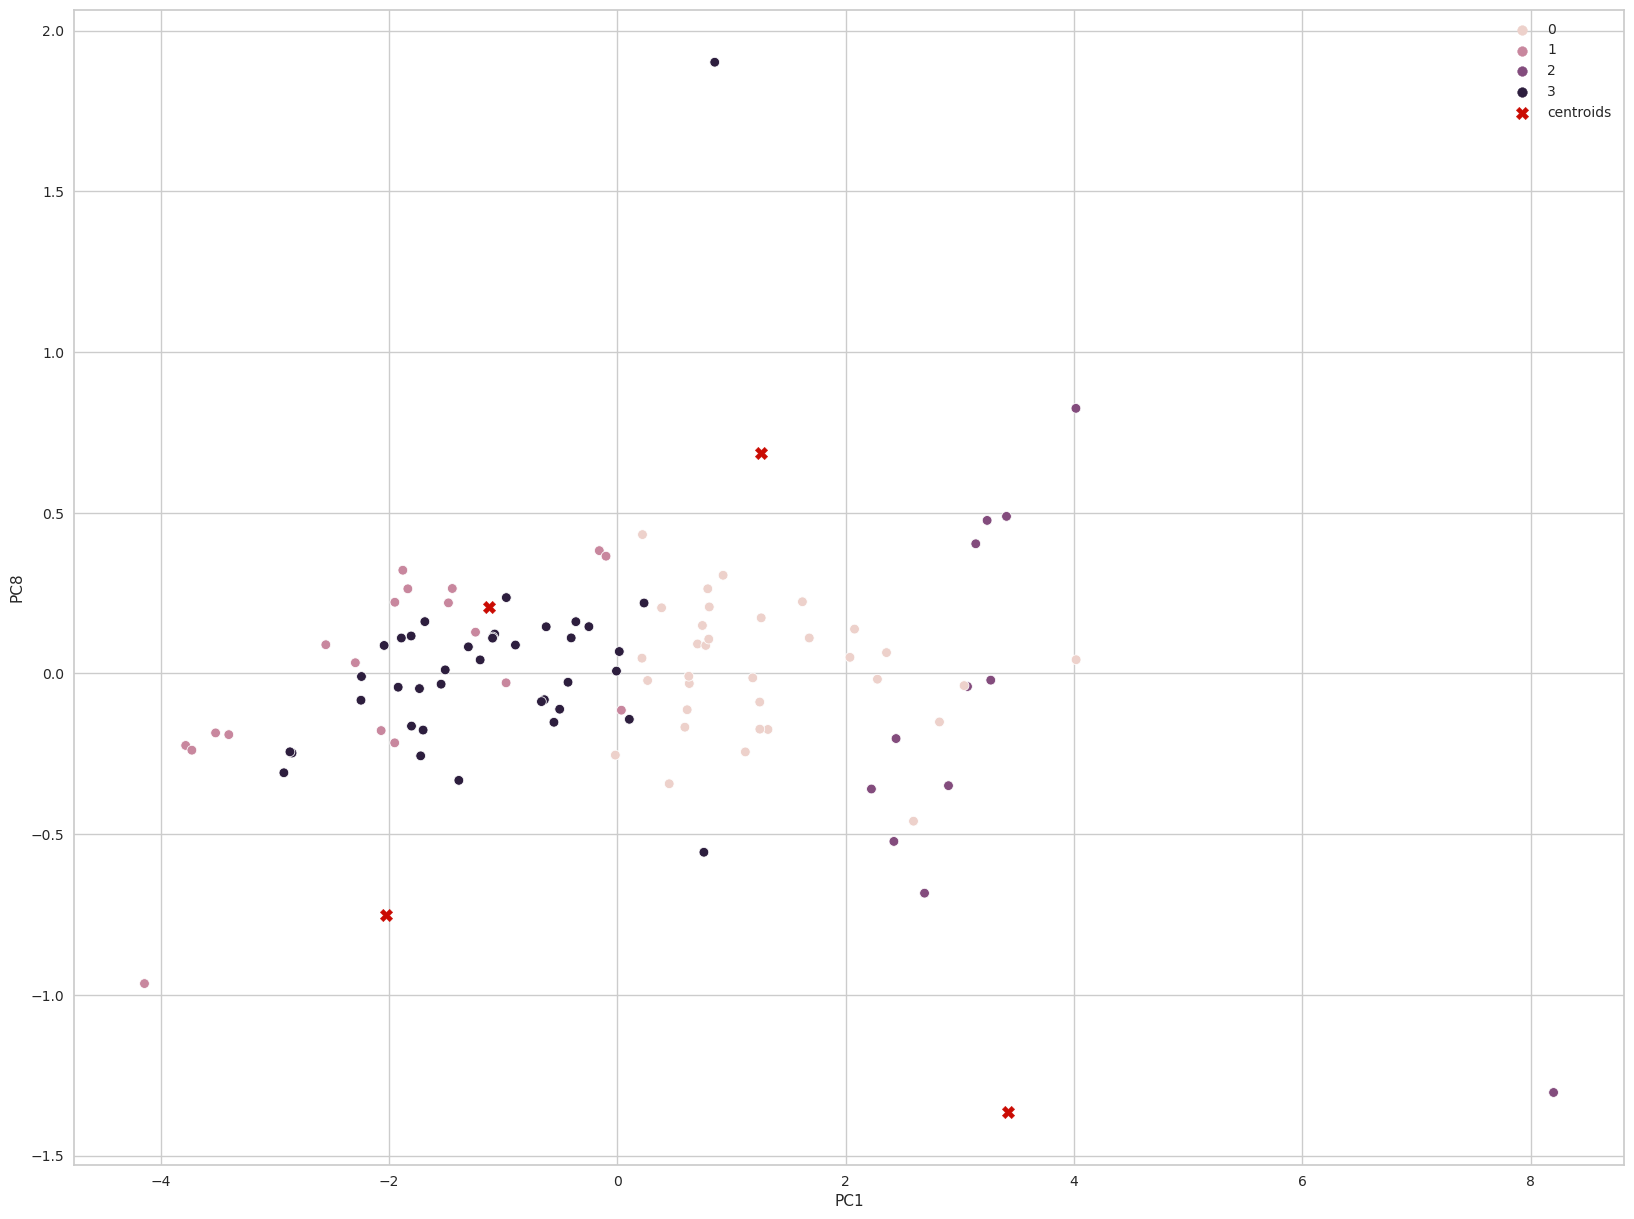

In [73]:
#Visulazing clusters
sb.scatterplot(data=data2, x="PC1", y="PC8", hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], 
            marker="X", c="r", s=80, label="centroids")
plt.legend()
plt.show()